In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import requests

# 1. Download unet_parts.py (building blocks)
if Path("unet_parts.py").is_file():
    print("unet_parts.py already exists")
else:
    print("Downloading unet_parts.py")
    url = "https://raw.githubusercontent.com/milesial/Pytorch-UNet/67bf11b4db4c5f2891bd7e8e7f58bcde8ee2d2db/unet/unet_parts.py"
    r = requests.get(url)
    with open("unet_parts.py", "wb") as f:
        f.write(r.content)

from unet_parts import *

# 2. UNet Model
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=True):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

# 3. Custom Dataset
class DeblurDataset(Dataset):
    def __init__(self, blur_dir, sharp_dir, transform=None):
        self.blur_dir = blur_dir
        self.sharp_dir = sharp_dir
        self.blur_imgs = sorted(os.listdir(blur_dir))
        self.sharp_imgs = sorted(os.listdir(sharp_dir))
        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.blur_imgs)

    def __getitem__(self, idx):
        blur_path = os.path.join(self.blur_dir, self.blur_imgs[idx])
        sharp_path = os.path.join(self.sharp_dir, self.sharp_imgs[idx])
        blur = Image.open(blur_path).convert("RGB")
        sharp = Image.open(sharp_path).convert("RGB")
        return self.transform(blur), self.transform(sharp)

# 4. Data Loaders
def get_dataloaders(blur_dir, sharp_dir, batch_size=8):
    dataset = DeblurDataset(blur_dir, sharp_dir)
    val_split = int(0.8 * len(dataset))
    train_set, test_set = torch.utils.data.random_split(dataset, [val_split, len(dataset) - val_split])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

# 5. Train UNet
def train_unet(model, train_loader, test_loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for blur, sharp in train_loader:
            blur, sharp = blur.to(device), sharp.to(device)
            pred = model(blur)
            loss = criterion(pred, sharp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"[{epoch+1}/{epochs}] Train Loss: {train_loss:.6f}")

        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for blur, sharp in test_loader:
                blur, sharp = blur.to(device), sharp.to(device)
                pred = model(blur)
                loss = criterion(pred, sharp)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        print(f"[{epoch+1}/{epochs}] Test Loss: {test_loss:.6f}")

# 6. Visualize Predictions
def visualize(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        for blur, sharp in test_loader:
            blur = blur.to(device)
            pred = model(blur)
            pred_img = pred[0].cpu().permute(1, 2, 0).numpy()
            gt_img = sharp[0].permute(1, 2, 0).numpy()
            input_img = blur[0].cpu().permute(1, 2, 0).numpy()

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input (Blurred)")
            plt.imshow(np.clip(input_img, 0, 1))
            plt.subplot(1, 3, 2)
            plt.title("Output (Predicted Sharp)")
            plt.imshow(np.clip(pred_img, 0, 1))
            plt.subplot(1, 3, 3)
            plt.title("Ground Truth")
            plt.imshow(np.clip(gt_img, 0, 1))
            plt.show()
            break


[1/20] Train Loss: 0.085541
[1/20] Test Loss: 0.039813
[2/20] Train Loss: 0.047478
[2/20] Test Loss: 0.042885
[3/20] Train Loss: 0.045536
[3/20] Test Loss: 0.038449
[4/20] Train Loss: 0.044002
[4/20] Test Loss: 0.039030
[5/20] Train Loss: 0.044787
[5/20] Test Loss: 0.038646
[6/20] Train Loss: 0.043190
[6/20] Test Loss: 0.038849
[7/20] Train Loss: 0.042591
[7/20] Test Loss: 0.037490
[8/20] Train Loss: 0.042987
[8/20] Test Loss: 0.036115
[9/20] Train Loss: 0.043709
[9/20] Test Loss: 0.040185
[10/20] Train Loss: 0.043460
[10/20] Test Loss: 0.037047
[11/20] Train Loss: 0.042667
[11/20] Test Loss: 0.038381
[12/20] Train Loss: 0.041907
[12/20] Test Loss: 0.038541
[13/20] Train Loss: 0.042295
[13/20] Test Loss: 0.036294
[14/20] Train Loss: 0.041250
[14/20] Test Loss: 0.037465
[15/20] Train Loss: 0.041979
[15/20] Test Loss: 0.036823
[16/20] Train Loss: 0.042016
[16/20] Test Loss: 0.036536
[17/20] Train Loss: 0.043143
[17/20] Test Loss: 0.036561
[18/20] Train Loss: 0.041750
[18/20] Test Loss: 0

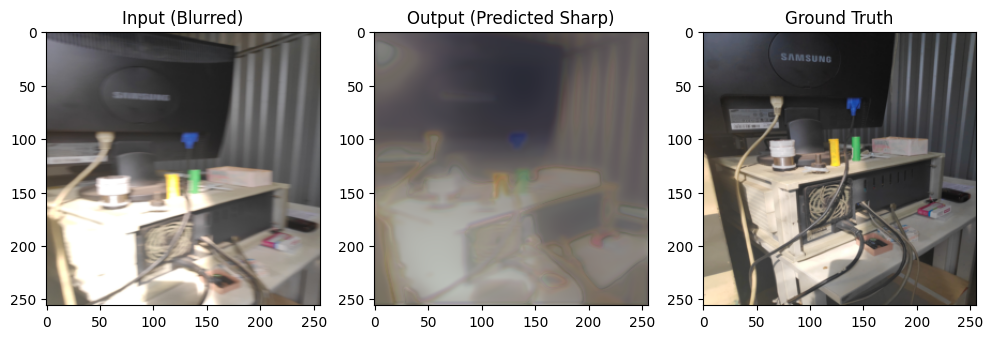

In [ ]:
import kagglehub
root_dir = kagglehub.dataset_download("kwentar/blur-dataset")
mb_images = root_dir+'/motion_blurred'
sharp_images = root_dir+'/sharp'

train_loader, test_loader = get_dataloaders(mb_images, sharp_images)
model = UNet(n_channels=3, n_classes=3)
train_unet(model, train_loader, test_loader, epochs=20, lr=1e-3)
visualize(model, test_loader)

In [ ]:
import torchvision.utils as vutils
from pathlib import Path

def visualize_and_save(model, test_loader, output_dir="unet_outputs", max_batches=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Create output folders
    input_dir = Path(output_dir) / "input_blurred"
    pred_dir = Path(output_dir) / "predicted_sharp"
    gt_dir = Path(output_dir) / "ground_truth"
    input_dir.mkdir(parents=True, exist_ok=True)
    pred_dir.mkdir(parents=True, exist_ok=True)
    gt_dir.mkdir(parents=True, exist_ok=True)

    count = 0
    with torch.no_grad():
        for batch_idx, (blur, sharp) in enumerate(test_loader):
            blur = blur.to(device)
            pred = model(blur)

            for i in range(blur.size(0)):
                input_img = blur[i].cpu()
                pred_img = pred[i].cpu()
                gt_img = sharp[i].cpu()

                # Clamp values to the range [0, 1]
                input_img = input_img.clamp(0, 1)
                pred_img = pred_img.clamp(0, 1)
                gt_img = gt_img.clamp(0, 1)

                # Save using torchvision (expects float tensors in [0, 1] or uint8 in [0, 255])
                vutils.save_image(input_img, input_dir / f"{count:04d}.png")
                vutils.save_image(pred_img, pred_dir / f"{count:04d}.png")
                vutils.save_image(gt_img, gt_dir / f"{count:04d}.png")
                count += 1

            if batch_idx + 1 >= max_batches:
                break

    print(f"Saved {count} image triplets to {output_dir}")
visualize_and_save(model,test_loader,"/content/unet_outputs")

Saved 40 image triplets to /content/unet_outputs


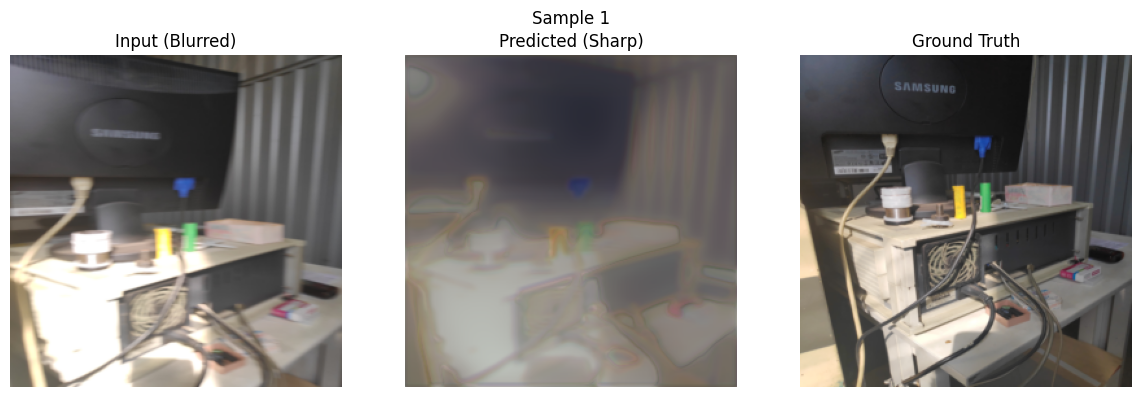

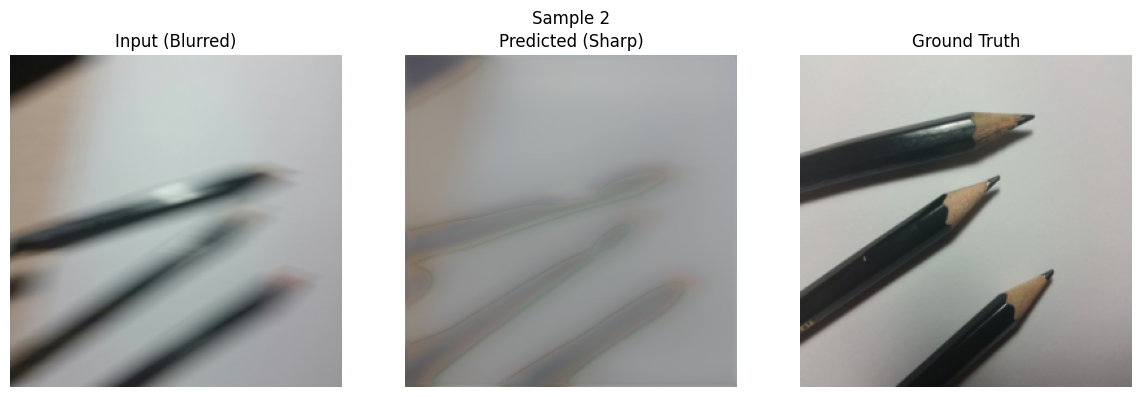

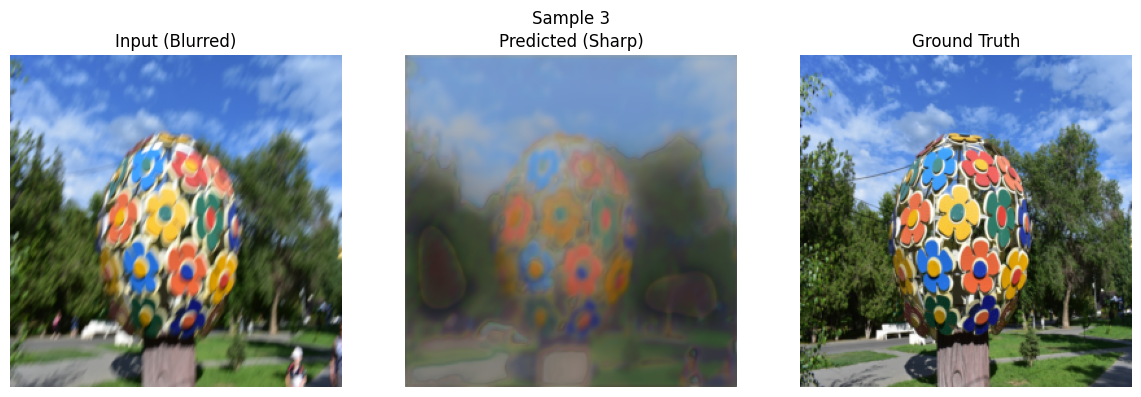

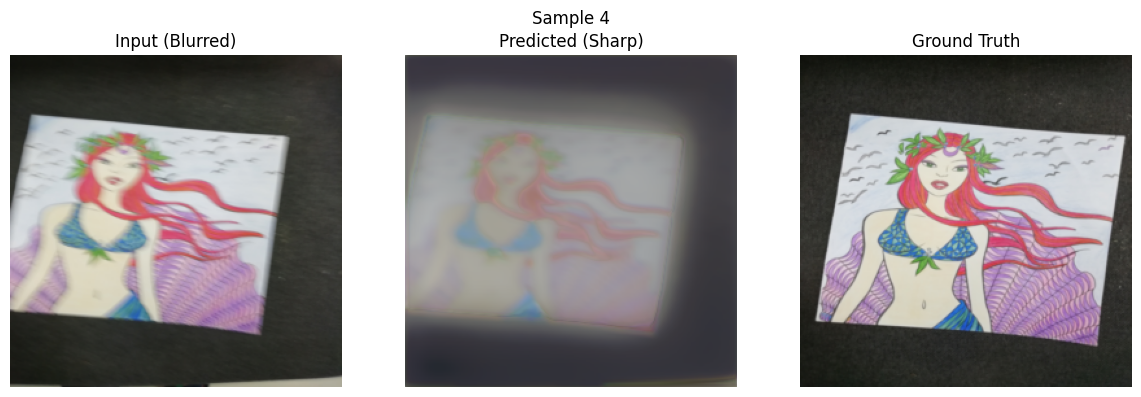

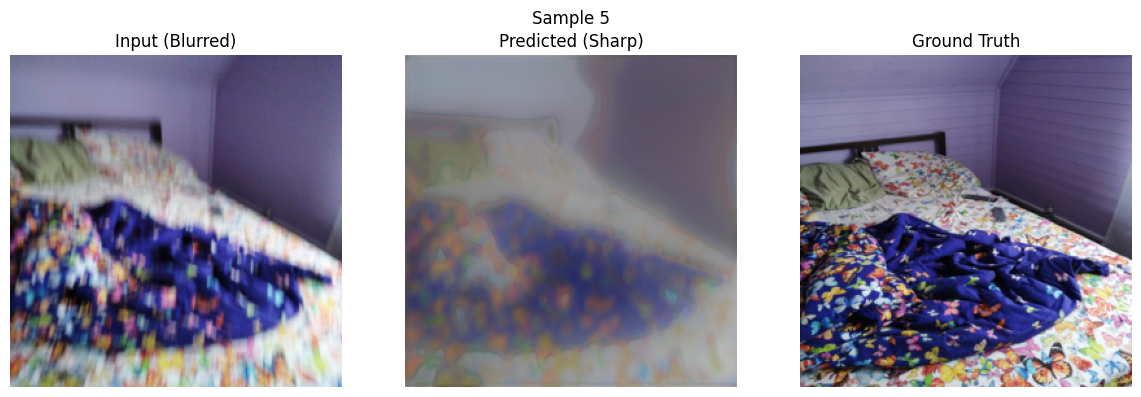

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def visualize_from_folder(output_dir="unet_outputs", num_samples=5):
    input_dir = os.path.join(output_dir, "input_blurred")
    pred_dir = os.path.join(output_dir, "predicted_sharp")
    gt_dir = os.path.join(output_dir, "ground_truth")

    filenames = sorted(os.listdir(pred_dir))[:num_samples]

    for i, filename in enumerate(filenames):
        input_img = Image.open(os.path.join(input_dir, filename))
        pred_img = Image.open(os.path.join(pred_dir, filename))
        gt_img = Image.open(os.path.join(gt_dir, filename))

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Sample {i+1}")

        plt.subplot(1, 3, 1)
        plt.title("Input (Blurred)")
        plt.imshow(input_img)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Predicted (Sharp)")
        plt.imshow(pred_img)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Ground Truth")
        plt.imshow(gt_img)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

visualize_from_folder("unet_outputs", num_samples=5)
